In [ ]:
# !pip uninstall community communities
# !pip install python-louvain

In [ ]:
# !pip install pandas networkx matplotlib seaborn plotly spacy scikit-learn numpy python-louvain

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import spacy
import re
from collections import defaultdict, Counter
from itertools import combinations
import numpy as np
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
# NER imports - both spaCy and HuggingFace options
try:
    nlp = spacy.load("en_core_web_sm")
    SPACY_AVAILABLE = True
except OSError:
    SPACY_AVAILABLE = False
    print("spaCy model not found. Will use HuggingFace BERT-NER if selected.")

try:
    from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
    HF_NER_AVAILABLE = True
except ImportError:
    HF_NER_AVAILABLE = False
    print("HuggingFace transformers not available. Install with: pip install transformers torch")


In [ ]:

class WorkersCompFraudDetector:
    def __init__(self, ner_method='spacy'):
        """
        Initialize fraud detector

        Args:
            ner_method (str): 'spacy' or 'huggingface' for NER approach
        """
        self.entities_df = None
        self.notes_df = None
        self.network = nx.Graph()
        self.entity_relationships = defaultdict(list)
        self.communities = {}
        self.fraud_entities = set()
        self.node_sizes = {}
        self.ner_method = ner_method

        # Production-ready datasets
        self.training_entities = None
        self.training_notes = None
        self.training_relationships = None

        # Centrality rankings
        self.centrality_rankings = {}

        # Initialize NER model based on selection
        self._initialize_ner()

    def _initialize_ner(self):
        """Initialize the selected NER model"""
        if self.ner_method == 'spacy':
            if not SPACY_AVAILABLE:
                raise ValueError("spaCy not available. Install with: python -m spacy download en_core_web_sm")
            self.ner_model = nlp
        elif self.ner_method == 'huggingface':
            if not HF_NER_AVAILABLE:
                raise ValueError("HuggingFace transformers not available. Install with: pip install transformers torch")
            # Suppress BERT warnings
            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.ner_model = pipeline("ner",
                                        model="dslim/bert-base-NER",
                                        aggregation_strategy="simple")
        else:
            raise ValueError("ner_method must be 'spacy' or 'huggingface'")

    def create_dataset(self):
        """Create the workers compensation dataset"""

        # Entities and fraud indicators
        entities_data = {
            'Name_Business': [
                'Dr. Michael Rodriguez', 'Sarah Thompson', 'Atlantic Medical Group', 'James Mitchell',
                'Lisa Chen', 'Robert Davis', 'Quick Heal Physical Therapy', 'Dr. Jennifer Walsh',
                'Maria Gonzalez', 'David Park', 'Thompson & Associates Law', 'Dr. Amanda Foster',
                'Kevin O\'Brien', 'Summit Construction LLC', 'Patricia Williams', 'Dr. Steven Kim',
                'Elite Diagnostics Center', 'Mark Johnson', 'Rachel Green', 'Tony Ricci',
                'Northside Medical Plaza', 'Dr. Carlos Mendez', 'Janet Murphy', 'Global Shipping Services',
                'Frank Harrison', 'Miller Defense Attorneys', 'Dr. Lisa Patel', 'Brandon Taylor',
                'Emma Watson', 'City Medical Associates', 'Dr. Thomas Burke', 'Angela Scott',
                'Precision Logistics Inc', 'Chris Adams', 'Valley Orthopedic Clinic', 'Dr. Nicole Zhang',
                'Metro Legal Group', 'Daniel Cooper', 'Samantha Lee', 'Progressive Wellness Center'
            ],
            'Type': [
                'Doctor', 'Regular Person', 'Business', 'Lawyer', 'Regular Person', 'Driver', 'Business',
                'Doctor', 'Regular Person', 'Driver', 'Business', 'Doctor', 'Regular Person', 'Business',
                'Regular Person', 'Doctor', 'Business', 'Driver', 'Lawyer', 'Regular Person', 'Business',
                'Doctor', 'Regular Person', 'Business', 'Driver', 'Business', 'Doctor', 'Regular Person',
                'Lawyer', 'Business', 'Doctor', 'Regular Person', 'Business', 'Driver', 'Business',
                'Doctor', 'Business', 'Regular Person', 'Lawyer', 'Business'
            ],
            'FraudList': [
                1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1
            ]
        }

        # Claim notes
        notes_data = {
            'ClaimNumber': [
                'WC-2024-001', 'WC-2024-001', 'WC-2024-001', 'WC-2024-002', 'WC-2024-002',
                'WC-2024-003', 'WC-2024-003', 'WC-2024-004', 'WC-2024-005', 'WC-2024-005',
                'WC-2024-006', 'WC-2024-007', 'WC-2024-007', 'WC-2024-008', 'WC-2024-009',
                'WC-2024-010', 'WC-2024-010', 'WC-2024-011', 'WC-2024-012', 'WC-2024-012'
            ],
            'NoteID': [f'N{i:03d}' for i in range(1, 21)],
            'Note': [
                "Initial claim received for workplace injury at Summit Construction LLC. Claimant Sarah Thompson reports back strain while lifting materials on 3/15/24. Witness Mark Johnson confirmed incident occurred during normal work duties. Medical attention sought at Northside Medical Plaza same day. Claim appears straightforward with proper documentation and witness corroboration.",

                "Follow-up with treating physician Dr. Jennifer Walsh regarding Sarah Thompson's back injury. Medical records show consistent findings with reported mechanism of injury. Claimant has been compliant with treatment recommendations and attending scheduled appointments. Dr. Walsh recommends 4 weeks light duty with lifting restrictions not to exceed 25 pounds. RTW plan being developed with Summit Construction LLC.",

                "Sarah Thompson returned to full duty on 4/20/24 as cleared by Dr. Jennifer Walsh. Total disability period was 35 days with successful return to work. Final medical report indicates good recovery with no permanent restrictions. Summit Construction LLC confirmed employee performance remains satisfactory. Claim ready for closure with total incurred costs of $8,450.",

                "New claim filed by David Park, driver for Global Shipping Services, alleging shoulder injury from vehicle rollover on 4/2/24. Initial investigation reveals conflicting witness statements about accident circumstances. Claimant sought treatment at Atlantic Medical Group with Dr. Michael Rodriguez. Police report indicates possible driver error. Additional investigation required before accepting liability.",

                "Surveillance conducted on David Park shows activities inconsistent with reported shoulder limitations. Video evidence obtained showing claimant performing overhead activities without apparent difficulty. Treatment records from Dr. Michael Rodriguez show minimal objective findings despite extensive symptom complaints. SIU referral initiated due to suspicious activity patterns and inconsistent medical presentation.",

                "Lisa Chen, warehouse worker, sustained ankle fracture after fall from ladder at Precision Logistics Inc on 4/10/24. Incident witnessed by Patricia Williams and Frank Harrison. Immediate medical attention provided by Dr. Amanda Foster at City Medical Associates. X-rays confirm displaced ankle fracture requiring surgical intervention. OSHA notification completed.",

                "Lisa Chen underwent successful ankle surgery performed by Dr. Thomas Burke at Valley Orthopedic Clinic. Post-operative recovery progressing as expected with no complications noted. Physical therapy scheduled to begin in 2 weeks at Progressive Wellness Center. Estimated time loss 12-16 weeks with gradual return to work anticipated. Employer Precision Logistics Inc cooperative with accommodation planning.",

                "Robert Davis, delivery driver, reports repetitive stress injury to wrists and forearms. Initial evaluation by Dr. Lisa Patel shows early signs of carpal tunnel syndrome. Work conditioning program recommended through Quick Heal Physical Therapy. Employer Global Shipping Services implementing ergonomic improvements to prevent similar injuries. Conservative treatment approach planned with regular monitoring.",

                "Complex claim involving Maria Gonzalez who sustained multiple injuries in workplace machinery accident. Legal representation by Emma Watson from Miller Defense Attorneys raising questions about safety violations. Dr. Carlos Mendez at Elite Diagnostics Center conducting extensive diagnostic testing. Third-party liability investigation ongoing with potential subrogation recovery. Claim reserves increased to $150,000.",

                "Settlement discussions initiated for Maria Gonzalez claim through attorney Emma Watson. Independent medical examination scheduled with Dr. Nicole Zhang to assess permanent disability rating. Employer safety improvements implemented following OSHA investigation. Structured settlement proposal under review with estimated total value $85,000. All parties working toward amicable resolution.",

                "Kevin O'Brien sustained chemical burn injury during routine maintenance at Atlantic Medical Group facility. Immediate treatment provided by Dr. Steven Kim showing second-degree burns requiring specialized care. Investigation reveals improper safety protocols and inadequate protective equipment. Employer implementing comprehensive safety training program. Workers compensation and potential third-party claims being evaluated.",

                "Suspicious claim filed by Tony Ricci alleging back injury with no witnesses present. Treatment sought exclusively at Quick Heal Physical Therapy with excessive therapy utilization. Legal representation by James Mitchell from Thompson & Associates Law raising red flags. Medical records show subjective complaints without objective findings. Comprehensive investigation initiated including social media monitoring.",

                "Investigation results for Tony Ricci claim reveal social media posts showing activities inconsistent with disability claims. Surveillance video confirms claimant engaging in strenuous physical activities. Treatment provider Quick Heal Physical Therapy has history of questionable billing practices. Attorney James Mitchell represents multiple suspicious claims. Claim denial recommended based on investigation findings.",

                "Janet Murphy, office administrator, developed gradual onset back pain over several months. Ergonomic assessment conducted by Brandon Taylor identified workstation deficiencies. Conservative treatment with Dr. Jennifer Walsh showing good progress. Workplace modifications implemented with employee reporting significant improvement. Short-term disability period expected with full recovery anticipated.",

                "Chris Adams sustained laceration injury requiring emergency surgery at Northside Medical Plaza. Dr. Amanda Foster performed successful repair with good healing progress noted. Employer Summit Construction LLC reviewing safety procedures to prevent similar incidents. Return to work expected within 6 weeks with proper wound care management. Medical costs well controlled with good prognosis.",

                "Daniel Cooper reports hearing loss allegedly from prolonged noise exposure at Metro Legal Group office location. Audiological testing by Dr. Nicole Zhang shows results inconsistent with claimed exposure levels. Investigation reveals claimant had pre-existing hearing conditions not disclosed during employment. Legal consultation with Rachel Green regarding coverage determination. Claim acceptance being contested.",

                "Hearing loss claim for Daniel Cooper requires additional medical evaluation by specialist Dr. Thomas Burke. Independent assessment confirms pre-existing condition significantly contributing to current hearing status. Employer Metro Legal Group documentation shows adequate hearing protection provided. Apportionment analysis needed to determine work-related percentage. Coverage decision pending medical review completion.",

                "Angela Scott sustained serious injury in forklift accident witnessed by multiple employees including Samantha Lee. Emergency treatment at Valley Orthopedic Clinic with Dr. Carlos Mendez revealed multiple fractures requiring extensive rehabilitation. Employer implementing enhanced safety training following incident investigation. Long-term disability anticipated with vocational rehabilitation services planned.",

                "Routine claim closure for Mark Johnson's minor laceration injury treated at City Medical Associates. Dr. Lisa Patel provided appropriate care with complete healing achieved within standard timeframe. Total medical costs $1,200 with 3 days time loss. Employer Global Shipping Services satisfied with claim handling. No complications or issues noted throughout claim lifecycle.",

                "Final settlement reached for Mark Johnson claim with total costs of $1,450 including medical expenses and wage replacement. Return to work successful with no ongoing restrictions or limitations. Dr. Lisa Patel released claimant to full duty status. Employer Global Shipping Services confirmed satisfactory job performance post-injury. Claim officially closed with reserves released."
            ]
        }

        self.entities_df = pd.DataFrame(entities_data)
        self.notes_df = pd.DataFrame(notes_data)
        self.fraud_entities = set(self.entities_df[self.entities_df['FraudList'] == 1]['Name_Business'].values)

        # Production-ready training datasets
        self.training_entities = self.entities_df.copy()
        self.training_notes = self.notes_df.copy()

        print(f"Dataset created: {len(self.entities_df)} entities, {len(self.notes_df)} notes")
        print(f"Fraud entities identified: {len(self.fraud_entities)}")
        print(f"Training datasets ready for production use")

    def extract_entities_ner(self):
        """Extract entities from notes using selected NER method"""

        print(f"Performing Named Entity Recognition using {self.ner_method.upper()}...")

        # Create entity patterns for better matching
        entity_patterns = {}
        for entity in self.entities_df['Name_Business']:
            # Create variations for better matching
            patterns = [entity]
            if 'Dr. ' in entity:
                patterns.append(entity.replace('Dr. ', ''))
            if ' LLC' in entity:
                patterns.append(entity.replace(' LLC', ''))
            entity_patterns[entity] = patterns

        note_entities = []

        for idx, row in self.notes_df.iterrows():
            note_text = row['Note']
            claim_num = row['ClaimNumber']
            note_id = row['NoteID']

            # Extract entities found in text
            found_entities = []

            # Custom entity matching (most reliable for our specific entities)
            for entity, patterns in entity_patterns.items():
                for pattern in patterns:
                    if pattern in note_text:
                        found_entities.append(entity)
                        break

            # Add NER results based on selected method
            if self.ner_method == 'spacy':
                doc = self.ner_model(note_text)
                for ent in doc.ents:
                    if ent.label_ in ['PERSON', 'ORG'] and ent.text not in found_entities:
                        # Check if it matches any of our entities
                        for entity in self.entities_df['Name_Business']:
                            if ent.text.lower() in entity.lower() or entity.lower() in ent.text.lower():
                                if entity not in found_entities:
                                    found_entities.append(entity)

            elif self.ner_method == 'huggingface':
                ner_results = self.ner_model(note_text)
                for ent in ner_results:
                    # FIXED: Add confidence threshold and filters to reduce false positives
                    if (ent['entity_group'] in ['PER', 'ORG'] and
                        ent['score'] > 0.9 and  # High confidence threshold
                        ent['word'] not in found_entities and
                        len(ent['word']) > 2):  # Filter out very short tokens
                        # Check if it matches any of our entities
                        for entity in self.entities_df['Name_Business']:
                            if ent['word'].lower() in entity.lower() or entity.lower() in ent['word'].lower():
                                if entity not in found_entities:
                                    found_entities.append(entity)

            # Store results
            for entity in found_entities:
                note_entities.append({
                    'ClaimNumber': claim_num,
                    'NoteID': note_id,
                    'Entity': entity,
                    'IsFraud': 1 if entity in self.fraud_entities else 0
                })

        self.extracted_entities = pd.DataFrame(note_entities)
        # Production dataset for relationships
        self.training_relationships = self.extracted_entities.copy()

        print(f"Extracted {len(self.extracted_entities)} entity mentions from notes")

        # Debug info for HuggingFace method
        if self.ner_method == 'huggingface':
            unique_entities = self.extracted_entities['Entity'].nunique()
            print(f"ℹ️  HuggingFace NER found {unique_entities} unique entities with confidence > 0.9")
            if len(self.extracted_entities) > 150:
                print("⚠️  High entity count detected - network may be very dense")

    def build_network(self):
        """Build network graph from entity co-occurrences"""

        print("Building network graph...")

        # Group entities by note to find co-occurrences
        note_groups = self.extracted_entities.groupby('NoteID')['Entity'].apply(list).reset_index()

        edge_weights = defaultdict(int)

        # Create edges for entities that appear together in notes
        for _, row in note_groups.iterrows():
            entities = row['Entity']
            if len(entities) > 1:
                # Create edges between all pairs in the note
                for entity1, entity2 in combinations(entities, 2):
                    edge = tuple(sorted([entity1, entity2]))
                    edge_weights[edge] += 1

        # Build NetworkX graph
        self.network = nx.Graph()

        # Add nodes with attributes
        for _, entity_row in self.entities_df.iterrows():
            entity = entity_row['Name_Business']
            self.network.add_node(entity,
                                type=entity_row['Type'],
                                fraud=entity_row['FraudList'])

        # Add edges with weights
        for (entity1, entity2), weight in edge_weights.items():
            self.network.add_edge(entity1, entity2, weight=weight)

        print(f"Network created: {self.network.number_of_nodes()} nodes, {self.network.number_of_edges()} edges")

    def detect_communities(self):
        """Apply community detection algorithms"""

        print("Detecting communities...")

        # Louvain community detection
        try:
            import community
            partition = community.best_partition(self.network, weight='weight')
        except (ImportError, AttributeError):
            # Fallback to NetworkX community detection
            from networkx.algorithms import community as nx_community
            communities_generator = nx_community.greedy_modularity_communities(self.network, weight='weight')
            partition = {}
            for i, comm in enumerate(communities_generator):
                for node in comm:
                    partition[node] = i

        # Add community information to nodes
        nx.set_node_attributes(self.network, partition, 'community')

        self.communities = {}
        for node, comm_id in partition.items():
            if comm_id not in self.communities:
                self.communities[comm_id] = []
            self.communities[comm_id].append(node)

        print(f"Found {len(self.communities)} communities")

        # Analyze fraud distribution in communities
        self.analyze_fraud_communities()

    def analyze_fraud_communities(self):
        """Analyze fraud distribution across communities"""

        print("\n=== FRAUD ANALYSIS BY COMMUNITY ===")

        community_analysis = []

        for comm_id, members in self.communities.items():
            fraud_count = sum(1 for member in members if member in self.fraud_entities)
            total_count = len(members)
            fraud_ratio = fraud_count / total_count if total_count > 0 else 0

            community_analysis.append({
                'Community': comm_id,
                'Total_Members': total_count,
                'Fraud_Members': fraud_count,
                'Fraud_Ratio': fraud_ratio,
                'Members': members
            })

            print(f"Community {comm_id}: {fraud_count}/{total_count} fraud entities ({fraud_ratio:.2%})")
            if fraud_ratio > 0.3:  # Highlight suspicious communities
                print(f"  ⚠️  HIGH FRAUD RISK COMMUNITY!")
                print(f"  Members: {', '.join(members)}")

        self.community_analysis = pd.DataFrame(community_analysis)

    def calculate_node_importance(self):
        """Calculate node importance using centrality measures"""

        print("Calculating node importance...")
        print("ℹ️  Importance Score = 40% Degree Centrality + 30% Betweenness Centrality + 30% Eigenvector Centrality")

        # Calculate various centrality measures
        degree_centrality = nx.degree_centrality(self.network)
        betweenness_centrality = nx.betweenness_centrality(self.network, weight='weight')
        eigenvector_centrality = nx.eigenvector_centrality(self.network, weight='weight')

        # Combine centralities (weighted average)
        importance_scores = {}
        centrality_data = []

        for node in self.network.nodes():
            importance = (0.4 * degree_centrality[node] +
                         0.3 * betweenness_centrality[node] +
                         0.3 * eigenvector_centrality[node])
            importance_scores[node] = importance

            # Store for ranking tables
            centrality_data.append({
                'Entity': node,
                'Degree_Centrality': degree_centrality[node],
                'Betweenness_Centrality': betweenness_centrality[node],
                'Eigenvector_Centrality': eigenvector_centrality[node],
                'Combined_Importance': importance,
                'Is_Fraud': 1 if node in self.fraud_entities else 0
            })

        # Create ranking tables
        centrality_df = pd.DataFrame(centrality_data)

        self.centrality_rankings = {
            'by_degree': centrality_df.sort_values('Degree_Centrality', ascending=False),
            'by_betweenness': centrality_df.sort_values('Betweenness_Centrality', ascending=False),
            'by_eigenvector': centrality_df.sort_values('Eigenvector_Centrality', ascending=False),
            'by_combined': centrality_df.sort_values('Combined_Importance', ascending=False)
        }

        # Normalize to node sizes (200-1000)
        max_importance = max(importance_scores.values())
        min_importance = min(importance_scores.values())

        self.node_sizes = {}
        for node, importance in importance_scores.items():
            normalized = (importance - min_importance) / (max_importance - min_importance)
            self.node_sizes[node] = 200 + (normalized * 800)  # 200-1000 range

        return importance_scores

    def create_community_table(self):
        """Create detailed community analysis table"""

        print("Creating community analysis table...")

        community_details = []

        for comm_id, members in self.communities.items():
            fraud_members = [m for m in members if m in self.fraud_entities]
            normal_members = [m for m in members if m not in self.fraud_entities]

            # Calculate community centrality
            community_centrality = np.mean([
                self.node_sizes[member] for member in members
            ])

            community_details.append({
                'Community_ID': comm_id,
                'Total_Members': len(members),
                'Fraud_Members': len(fraud_members),
                'Normal_Members': len(normal_members),
                'Fraud_Ratio': len(fraud_members) / len(members),
                'Avg_Centrality': community_centrality,
                'Fraud_Entities': ', '.join(fraud_members),
                'Normal_Entities': ', '.join(normal_members),
                'Risk_Level': 'HIGH' if len(fraud_members) / len(members) > 0.4 else
                           'MEDIUM' if len(fraud_members) / len(members) > 0.2 else 'LOW'
            })

        self.community_table = pd.DataFrame(community_details)
        self.community_table = self.community_table.sort_values(['Fraud_Ratio', 'Avg_Centrality'],
                                                               ascending=[False, False])

        print("\n📊 DETAILED COMMUNITY ANALYSIS TABLE:")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(self.community_table[['Community_ID', 'Total_Members', 'Fraud_Members',
                                   'Fraud_Ratio', 'Risk_Level', 'Avg_Centrality']].round(3))

        return self.community_table

    def visualize_individual_communities(self):
        """Create separate visualizations for each community - FIXED matplotlib axes handling"""

        print("Creating individual community visualizations...")

        num_communities = len(self.communities)
        cols = min(3, num_communities)
        rows = (num_communities + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

        # FIXED: Handle different axes structures properly
        if num_communities == 1:
            axes = [axes]
        elif rows == 1 and cols > 1:
            axes = axes  # Already correct for single row, multiple columns
        elif rows > 1 and cols == 1:
            axes = axes  # Already correct for multiple rows, single column
        elif rows > 1 and cols > 1:
            axes = axes.flatten()  # Flatten for easy indexing
        else:
            axes = [axes]  # Single subplot case

        # Better contrasting colors: blues, yellows, oranges
        community_colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#d62728', '#9467bd',
                           '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

        for idx, (comm_id, members) in enumerate(self.communities.items()):
            ax = axes[idx]

            # Create subgraph for this community
            subgraph = self.network.subgraph(members)
            pos = nx.spring_layout(subgraph, k=1, iterations=50)

            # Node colors and sizes for this community
            node_colors = ['red' if node in self.fraud_entities else community_colors[comm_id % len(community_colors)]
                          for node in subgraph.nodes()]
            node_sizes = [self.node_sizes[node] for node in subgraph.nodes()]

            # Draw community
            nx.draw(subgraph, pos, ax=ax,
                   node_color=node_colors,
                   node_size=node_sizes,
                   with_labels=True,
                   font_size=8,
                   edge_color='gray',
                   alpha=0.8)

            # Title with community stats
            fraud_count = len([m for m in members if m in self.fraud_entities])
            fraud_ratio = fraud_count / len(members)
            risk_level = 'HIGH' if fraud_ratio > 0.4 else 'MEDIUM' if fraud_ratio > 0.2 else 'LOW'

            ax.set_title(f'Community {comm_id}\n{fraud_count}/{len(members)} fraud ({fraud_ratio:.1%})\nRisk: {risk_level}',
                        fontsize=12, fontweight='bold')

        # Hide empty subplots
        for idx in range(num_communities, len(axes)):
            if idx < len(axes):
                axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()

    def visualize_network(self):
        """Create network visualizations with node importance"""

        print("Creating network visualizations...")

        # Calculate layout
        pos = nx.spring_layout(self.network, k=1, iterations=50)

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

        # Node sizes based on importance
        node_sizes = [self.node_sizes[node] for node in self.network.nodes()]

        # Better contrasting colors for communities
        community_colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#d62728', '#9467bd',
                           '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']

        # 1. Basic Network View
        ax1.set_title("Network View: Basic", fontsize=14, fontweight='bold')
        nx.draw(self.network, pos, ax=ax1,
                node_color='lightblue',
                node_size=node_sizes,
                with_labels=True,
                font_size=8,
                edge_color='gray',
                alpha=0.7)

        # 2. Fraud Overlay View
        ax2.set_title("Network View: Fraud Overlay", fontsize=14, fontweight='bold')
        node_colors = ['red' if node in self.fraud_entities else 'lightblue'
                      for node in self.network.nodes()]
        nx.draw(self.network, pos, ax=ax2,
                node_color=node_colors,
                node_size=node_sizes,
                with_labels=True,
                font_size=8,
                edge_color='gray',
                alpha=0.7)

        # Add legend
        red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fraud Entity')
        blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Normal Entity')
        ax2.legend(handles=[red_patch, blue_patch], loc='upper right')

        # 3. Communities View
        ax3.set_title("Network View: Communities", fontsize=14, fontweight='bold')
        node_colors = []
        for node in self.network.nodes():
            comm_id = self.network.nodes[node]['community']
            node_colors.append(community_colors[comm_id % len(community_colors)])

        nx.draw(self.network, pos, ax=ax3,
                node_color=node_colors,
                node_size=node_sizes,
                with_labels=True,
                font_size=8,
                edge_color='gray',
                alpha=0.7)

        # 4. Combined View
        ax4.set_title("Network View: Communities + Fraud", fontsize=14, fontweight='bold')
        node_colors = []
        for node in self.network.nodes():
            if node in self.fraud_entities:
                node_colors.append('red')
            else:
                comm_id = self.network.nodes[node]['community']
                node_colors.append(community_colors[comm_id % len(community_colors)])

        nx.draw(self.network, pos, ax=ax4,
                node_color=node_colors,
                node_size=node_sizes,
                with_labels=True,
                font_size=8,
                edge_color='gray',
                alpha=0.7)

        plt.tight_layout()
        plt.show()

    def create_interactive_visualization(self):
        """Create interactive Plotly visualization with node importance"""

        print("Creating interactive visualization...")

        # Calculate layout
        pos = nx.spring_layout(self.network, k=1, iterations=50)

        # Prepare edge traces
        edge_x = []
        edge_y = []
        edge_weights = []

        for edge in self.network.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_weights.append(self.network.edges[edge].get('weight', 1))

        edge_trace = go.Scatter(x=edge_x, y=edge_y,
                               line=dict(width=2, color='#888'),
                               hoverinfo='none',
                               mode='lines')

        # Prepare node traces
        node_x = []
        node_y = []
        node_text = []
        node_color = []
        node_size = []

        for node in self.network.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)

            # Node info
            node_info = self.entities_df[self.entities_df['Name_Business'] == node].iloc[0]
            community_id = self.network.nodes[node]['community']
            importance = self.node_sizes[node]

            # Hover text
            text = f"Name: {node}<br>"
            text += f"Type: {node_info['Type']}<br>"
            text += f"Community: {community_id}<br>"
            text += f"Fraud Flag: {'Yes' if node in self.fraud_entities else 'No'}<br>"
            text += f"Connections: {self.network.degree(node)}<br>"
            text += f"Importance Score: {importance:.1f}"
            node_text.append(text)

            # Color and size based on fraud status and importance
            if node in self.fraud_entities:
                node_color.append('red')
            else:
                node_color.append('lightblue')

            # Size based on importance (scale for Plotly)
            node_size.append(importance / 25)  # Scale down for Plotly

        node_trace = go.Scatter(x=node_x, y=node_y,
                               mode='markers+text',
                               hoverinfo='text',
                               text=[name.split()[-1] for name in self.network.nodes()],  # Show last name
                               textposition="middle center",
                               hovertext=node_text,
                               marker=dict(size=node_size,
                                         color=node_color,
                                         line=dict(width=2, color='black')))

        # Create figure
        fig = go.Figure(data=[edge_trace, node_trace],
                       layout=go.Layout(
                           title='Network View: Interactive (Node size = Importance)',
                           titlefont_size=16,
                           showlegend=False,
                           hovermode='closest',
                           margin=dict(b=20,l=5,r=5,t=40),
                           annotations=[ dict(
                               text="Red nodes = Fraud indicators<br>Blue nodes = Normal entities<br>Node size = Network importance<br>Hover for details",
                               showarrow=False,
                               xref="paper", yref="paper",
                               x=0.005, y=-0.002,
                               xanchor="left", yanchor="bottom",
                               font=dict(color="black", size=12)
                           )],
                           xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                           yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

        fig.show()

    def get_centrality_rankings(self):
        """Return sorted centrality rankings for production use"""
        return self.centrality_rankings

    def get_training_datasets(self):
        """Return production-ready training datasets"""
        return {
            'entities': self.training_entities,
            'notes': self.training_notes,
            'relationships': self.training_relationships
        }

    def generate_fraud_report(self):
        """Generate comprehensive fraud analysis report"""

        print("\n" + "="*80)
        print("WORKERS COMPENSATION FRAUD DETECTION REPORT")
        print("="*80)

        # Overall statistics
        total_entities = len(self.entities_df)
        fraud_entities_count = len(self.fraud_entities)
        fraud_rate = fraud_entities_count / total_entities

        print(f"\n📊 OVERALL STATISTICS:")
        print(f"Total Entities: {total_entities}")
        print(f"Fraud Entities: {fraud_entities_count}")
        print(f"Overall Fraud Rate: {fraud_rate:.2%}")

        # Network statistics
        print(f"\n🕸️ NETWORK STATISTICS:")
        print(f"Nodes: {self.network.number_of_nodes()}")
        print(f"Edges: {self.network.number_of_edges()}")
        print(f"Density: {nx.density(self.network):.3f}")
        print(f"Communities Detected: {len(self.communities)}")

        # High-risk communities
        print(f"\n⚠️ HIGH-RISK COMMUNITIES (>30% fraud rate):")
        high_risk_communities = self.community_analysis[
            self.community_analysis['Fraud_Ratio'] > 0.3
        ].sort_values('Fraud_Ratio', ascending=False)

        if len(high_risk_communities) > 0:
            for _, comm in high_risk_communities.iterrows():
                print(f"Community {comm['Community']}: {comm['Fraud_Ratio']:.1%} fraud rate")
                print(f"  Members: {', '.join(comm['Members'])}")
                print()
        else:
            print("No communities with >30% fraud rate detected.")

        # Central fraud entities
        print(f"\n🎯 MOST CONNECTED FRAUD ENTITIES:")
        fraud_centrality = {}
        for node in self.fraud_entities:
            if node in self.network:
                fraud_centrality[node] = self.network.degree(node)

        top_fraud_entities = sorted(fraud_centrality.items(),
                                  key=lambda x: x[1], reverse=True)[:5]

        for entity, connections in top_fraud_entities:
            entity_type = self.entities_df[
                self.entities_df['Name_Business'] == entity
            ]['Type'].iloc[0]
            print(f"{entity} ({entity_type}): {connections} connections")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        print("1. Investigate high-risk communities for coordinated fraud")
        print("2. Monitor central fraud entities for new claim patterns")
        print("3. Review claims involving multiple fraud-flagged entities")
        print("4. Implement enhanced scrutiny for entities in dense fraud clusters")

        return {
            'total_entities': total_entities,
            'fraud_count': fraud_entities_count,
            'fraud_rate': fraud_rate,
            'high_risk_communities': len(high_risk_communities),
            'top_fraud_entities': top_fraud_entities
        }

    def run_complete_analysis(self):
        """Run the complete fraud detection analysis"""

        print("🚀 Starting Workers Compensation Fraud Detection Analysis")
        print("="*60)

        # Step 1: Create dataset
        self.create_dataset()

        # Step 2: Extract entities using NER
        self.extract_entities_ner()

        # Step 3: Build network
        self.build_network()

        # Step 4: Detect communities
        self.detect_communities()

        # Step 5: Calculate node importance
        self.calculate_node_importance()

        # Step 6: Create community table
        self.create_community_table()

        # Step 7: Create visualizations
        self.visualize_network()
        self.visualize_individual_communities()
        self.create_interactive_visualization()

        # Step 8: Generate report
        results = self.generate_fraud_report()

        print("\n✅ Analysis complete!")
        return results

In [ ]:

class NERAccuracyTester:
    """
    Module to test and compare accuracy of different NER methods
    against ground truth entity extractions
    """

    def __init__(self, ground_truth_entities, notes_df):
        """
        Initialize with ground truth data

        Args:
            ground_truth_entities: DataFrame with known entities
            notes_df: DataFrame with claim notes
        """
        self.ground_truth_entities = ground_truth_entities
        self.notes_df = notes_df
        self.known_entities = set(ground_truth_entities['Name_Business'].values)
        self.results = {}

    def extract_with_method(self, method_name, detector_instance):
        """
        Extract entities using a specific method through detector instance

        Args:
            method_name: Name of the method ('spacy' or 'huggingface')
            detector_instance: Instance of WorkersCompFraudDetector with the method
        """
        print(f"\n🔍 Testing {method_name.upper()} NER method...")

        # Run extraction
        detector_instance.extract_entities_ner()
        extracted_df = detector_instance.extracted_entities.copy()

        # Store results
        self.results[method_name] = {
            'extracted_df': extracted_df,
            'entity_counts': extracted_df.groupby('Entity').size().to_dict(),
            'total_extractions': len(extracted_df),
            'unique_entities': extracted_df['Entity'].nunique(),
            'notes_with_entities': extracted_df['NoteID'].nunique()
        }

        print(f"✅ {method_name.upper()}: {len(extracted_df)} total extractions, {extracted_df['Entity'].nunique()} unique entities")

    def calculate_accuracy_metrics(self):
        """Calculate precision, recall, F1 for each method against ground truth"""

        print("\n📊 CALCULATING ACCURACY METRICS...")

        metrics_summary = {}

        for method_name, results in self.results.items():
            extracted_entities = set(results['extracted_df']['Entity'].unique())

            # Calculate set-based metrics
            true_positives = extracted_entities.intersection(self.known_entities)
            false_positives = extracted_entities - self.known_entities
            false_negatives = self.known_entities - extracted_entities

            # Calculate metrics
            precision = len(true_positives) / len(extracted_entities) if extracted_entities else 0
            recall = len(true_positives) / len(self.known_entities)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            metrics_summary[method_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'true_positives': len(true_positives),
                'false_positives': len(false_positives),
                'false_negatives': len(false_negatives),
                'tp_entities': list(true_positives),
                'fp_entities': list(false_positives),
                'fn_entities': list(false_negatives)
            }

            print(f"\n{method_name.upper()} Metrics:")
            print(f"  Precision: {precision:.3f}")
            print(f"  Recall: {recall:.3f}")
            print(f"  F1 Score: {f1:.3f}")
            print(f"  True Positives: {len(true_positives)}")
            print(f"  False Positives: {len(false_positives)}")
            print(f"  False Negatives: {len(false_negatives)}")

        self.metrics_summary = metrics_summary
        return metrics_summary

    def analyze_entity_differences(self):
        """Analyze which entities each method finds vs misses"""

        print("\n🔍 ENTITY EXTRACTION ANALYSIS...")

        if len(self.results) < 2:
            print("Need at least 2 methods to compare")
            return

        methods = list(self.results.keys())
        method1, method2 = methods[0], methods[1]

        entities1 = set(self.results[method1]['extracted_df']['Entity'].unique())
        entities2 = set(self.results[method2]['extracted_df']['Entity'].unique())

        # Compare extractions
        both_found = entities1.intersection(entities2)
        only_method1 = entities1 - entities2
        only_method2 = entities2 - entities1

        print(f"\n📈 EXTRACTION COMPARISON ({method1.upper()} vs {method2.upper()}):")
        print(f"Both methods found: {len(both_found)} entities")
        print(f"Only {method1}: {len(only_method1)} entities")
        print(f"Only {method2}: {len(only_method2)} entities")

        if only_method1:
            print(f"\n🔸 Entities found only by {method1.upper()}:")
            for entity in sorted(only_method1):
                is_real = "✓ REAL" if entity in self.known_entities else "✗ FALSE POSITIVE"
                print(f"  - {entity} ({is_real})")

        if only_method2:
            print(f"\n🔸 Entities found only by {method2.upper()}:")
            for entity in sorted(only_method2):
                is_real = "✓ REAL" if entity in self.known_entities else "✗ FALSE POSITIVE"
                print(f"  - {entity} ({is_real})")

        return {
            'both_found': both_found,
            'only_method1': only_method1,
            'only_method2': only_method2
        }

    def analyze_extraction_frequency(self):
        """Analyze how frequently each entity is extracted"""

        print("\n📊 EXTRACTION FREQUENCY ANALYSIS...")

        for method_name, results in self.results.items():
            print(f"\n{method_name.upper()} - Top 10 Most Extracted Entities:")
            entity_counts = Counter(results['extracted_df']['Entity'])
            for entity, count in entity_counts.most_common(10):
                is_fraud = "🔴 FRAUD" if entity in self.ground_truth_entities[self.ground_truth_entities['FraudList']==1]['Name_Business'].values else "🔵 NORMAL"
                print(f"  {entity}: {count} times ({is_fraud})")

    def visualize_comparison(self):
        """Create visualizations comparing the methods"""

        if not hasattr(self, 'metrics_summary'):
            self.calculate_accuracy_metrics()

        # Create comparison plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        methods = list(self.metrics_summary.keys())

        # 1. Metrics comparison
        metrics = ['precision', 'recall', 'f1_score']
        method1_scores = [self.metrics_summary[methods[0]][m] for m in metrics]
        method2_scores = [self.metrics_summary[methods[1]][m] for m in metrics] if len(methods) > 1 else [0,0,0]

        x = np.arange(len(metrics))
        width = 0.35

        ax1.bar(x - width/2, method1_scores, width, label=methods[0].upper(), alpha=0.8)
        if len(methods) > 1:
            ax1.bar(x + width/2, method2_scores, width, label=methods[1].upper(), alpha=0.8)

        ax1.set_ylabel('Score')
        ax1.set_title('NER Method Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
        ax1.legend()
        ax1.set_ylim(0, 1)

        # 2. Extraction counts
        extraction_counts = [self.results[method]['total_extractions'] for method in methods]
        ax2.bar(methods, extraction_counts, alpha=0.7, color=['skyblue', 'lightcoral'][:len(methods)])
        ax2.set_ylabel('Total Extractions')
        ax2.set_title('Total Entity Extractions by Method')
        for i, count in enumerate(extraction_counts):
            ax2.text(i, count + 0.01*max(extraction_counts), str(count), ha='center')

        # 3. Unique entities found
        unique_counts = [self.results[method]['unique_entities'] for method in methods]
        ax3.bar(methods, unique_counts, alpha=0.7, color=['lightgreen', 'orange'][:len(methods)])
        ax3.set_ylabel('Unique Entities')
        ax3.set_title('Unique Entities Found by Method')
        for i, count in enumerate(unique_counts):
            ax3.text(i, count + 0.01*max(unique_counts), str(count), ha='center')

        # 4. True/False Positives
        if len(methods) >= 2:
            tp_fp_data = []
            for method in methods:
                metrics = self.metrics_summary[method]
                tp_fp_data.append([metrics['true_positives'], metrics['false_positives']])

            tp_fp_data = np.array(tp_fp_data).T

            x = np.arange(len(methods))
            ax4.bar(x, tp_fp_data[0], label='True Positives', alpha=0.8, color='green')
            ax4.bar(x, tp_fp_data[1], bottom=tp_fp_data[0], label='False Positives', alpha=0.8, color='red')

            ax4.set_ylabel('Count')
            ax4.set_title('True vs False Positives')
            ax4.set_xticks(x)
            ax4.set_xticklabels([m.upper() for m in methods])
            ax4.legend()

        plt.tight_layout()
        plt.show()

    def generate_accuracy_report(self):
        """Generate comprehensive accuracy report"""

        print("\n" + "="*80)
        print("NER ACCURACY TESTING REPORT")
        print("="*80)

        print(f"\n📋 GROUND TRUTH:")
        print(f"Total known entities: {len(self.known_entities)}")
        print(f"Total notes analyzed: {len(self.notes_df)}")

        # Calculate and display metrics
        self.calculate_accuracy_metrics()

        # Find best performing method
        best_method = max(self.metrics_summary.keys(),
                         key=lambda x: self.metrics_summary[x]['f1_score'])

        print(f"\n🏆 BEST PERFORMING METHOD: {best_method.upper()}")
        best_metrics = self.metrics_summary[best_method]
        print(f"F1 Score: {best_metrics['f1_score']:.3f}")
        print(f"Precision: {best_metrics['precision']:.3f}")
        print(f"Recall: {best_metrics['recall']:.3f}")

        # Analyze differences
        differences = self.analyze_entity_differences()

        # Show false positives for each method
        print(f"\n❌ FALSE POSITIVES BY METHOD:")
        for method_name, metrics in self.metrics_summary.items():
            if metrics['fp_entities']:
                print(f"\n{method_name.upper()} false positives ({len(metrics['fp_entities'])}):")
                for fp in sorted(metrics['fp_entities']):
                    print(f"  - {fp}")
            else:
                print(f"\n{method_name.upper()}: No false positives!")

        # Show missed entities
        print(f"\n❌ MISSED ENTITIES BY METHOD:")
        for method_name, metrics in self.metrics_summary.items():
            if metrics['fn_entities']:
                print(f"\n{method_name.upper()} missed entities ({len(metrics['fn_entities'])}):")
                for fn in sorted(metrics['fn_entities']):
                    print(f"  - {fn}")
            else:
                print(f"\n{method_name.upper()}: Found all entities!")

        return {
            'best_method': best_method,
            'metrics_summary': self.metrics_summary,
            'differences': differences if 'differences' in locals() else None
        }

def run_ner_accuracy_test(detector_class, entities_df, notes_df):
    """
    Run comprehensive NER accuracy testing

    Args:
        detector_class: WorkersCompFraudDetector class
        entities_df: Ground truth entities DataFrame
        notes_df: Notes DataFrame for testing
    """

    print("🚀 Starting NER Accuracy Testing...")

    # Initialize tester
    tester = NERAccuracyTester(entities_df, notes_df)

    # Test both methods
    methods_to_test = ['spacy', 'huggingface']

    for method in methods_to_test:
        try:
            print(f"\n🔬 Testing {method} method...")
            detector = detector_class(ner_method=method)
            detector.create_dataset()  # Load the data
            tester.extract_with_method(method, detector)
        except Exception as e:
            print(f"❌ Error testing {method}: {e}")
            continue

    # Run analysis
    if len(tester.results) >= 1:
        # Generate comprehensive report
        report = tester.generate_accuracy_report()

        # Show extraction frequency analysis
        tester.analyze_extraction_frequency()

        # Create visualizations
        if len(tester.results) >= 2:
            tester.visualize_comparison()

        return tester, report
    else:
        print("❌ No successful NER method tests completed")
        return None, None

🎯 WORKERS COMPENSATION FRAUD DETECTION WITH NER ACCURACY TESTING

📊 PART 1: STANDARD FRAUD DETECTION ANALYSIS
--------------------------------------------------
🚀 Starting Workers Compensation Fraud Detection Analysis
Dataset created: 40 entities, 20 notes
Fraud entities identified: 16
Training datasets ready for production use
Performing Named Entity Recognition using SPACY...
Extracted 74 entity mentions from notes
Building network graph...
Network created: 40 nodes, 92 edges
Detecting communities...
Found 6 communities

=== FRAUD ANALYSIS BY COMMUNITY ===
Community 0: 4/10 fraud entities (40.00%)
  ⚠️  HIGH FRAUD RISK COMMUNITY!
  Members: Dr. Lisa Patel, Kevin O'Brien, Robert Davis, Atlantic Medical Group, Dr. Steven Kim, David Park, City Medical Associates, Mark Johnson, Global Shipping Services, Dr. Michael Rodriguez
Community 1: 1/8 fraud entities (12.50%)
Community 2: 1/7 fraud entities (14.29%)
Community 3: 5/7 fraud entities (71.43%)
  ⚠️  HIGH FRAUD RISK COMMUNITY!
  Members

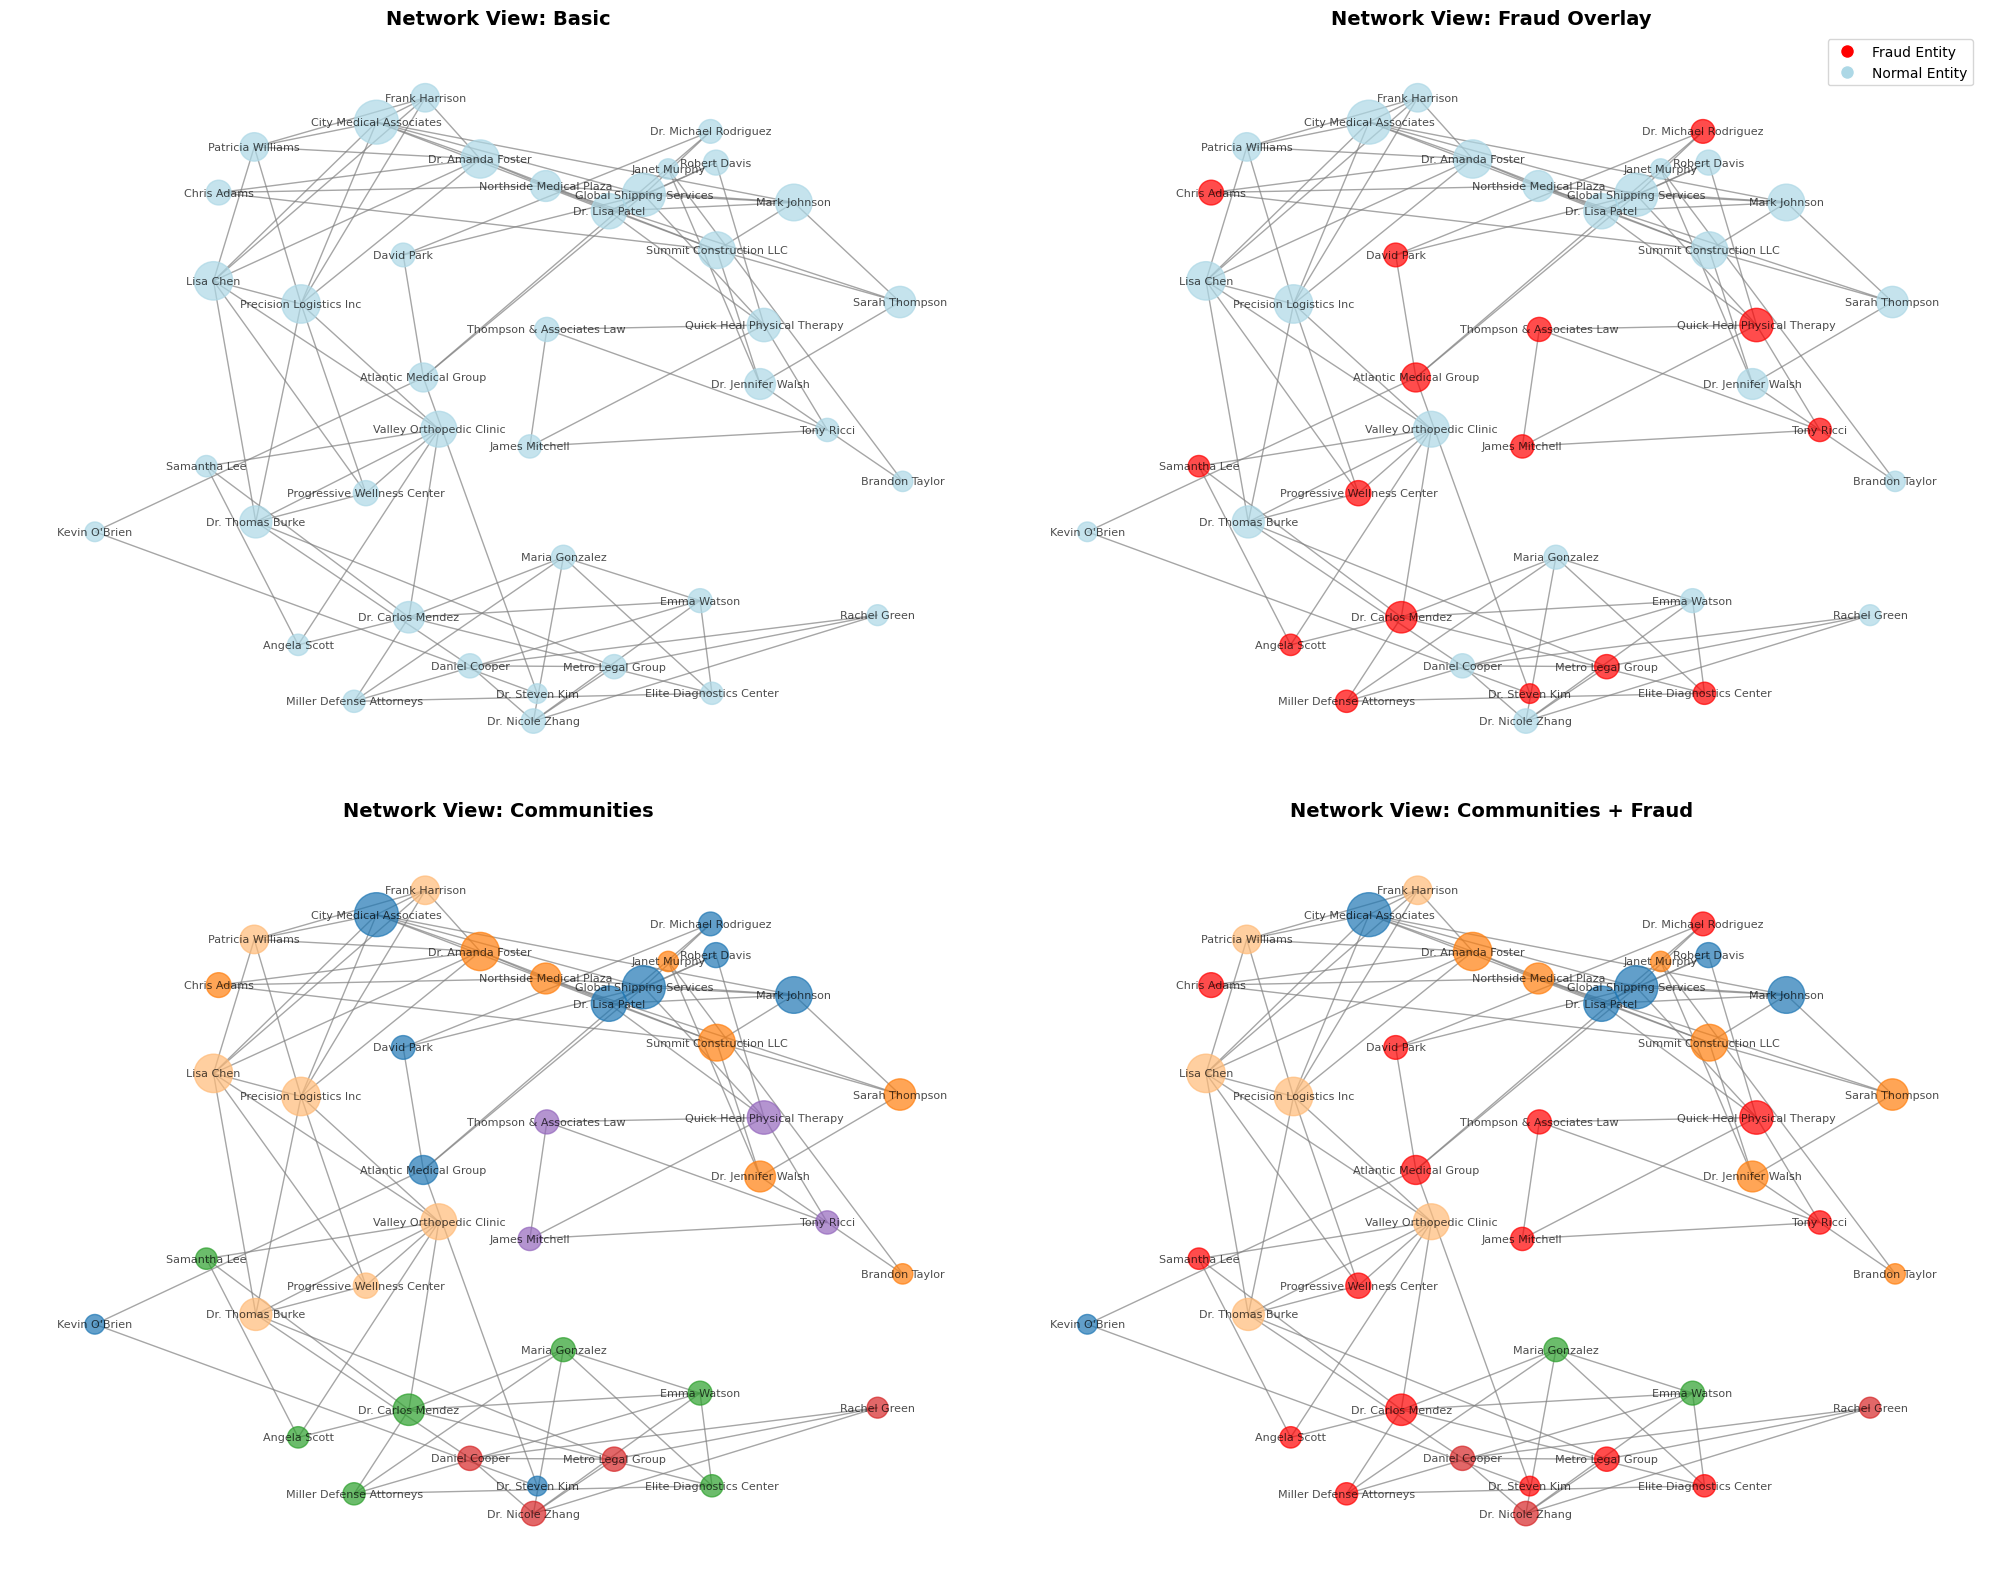

Creating individual community visualizations...


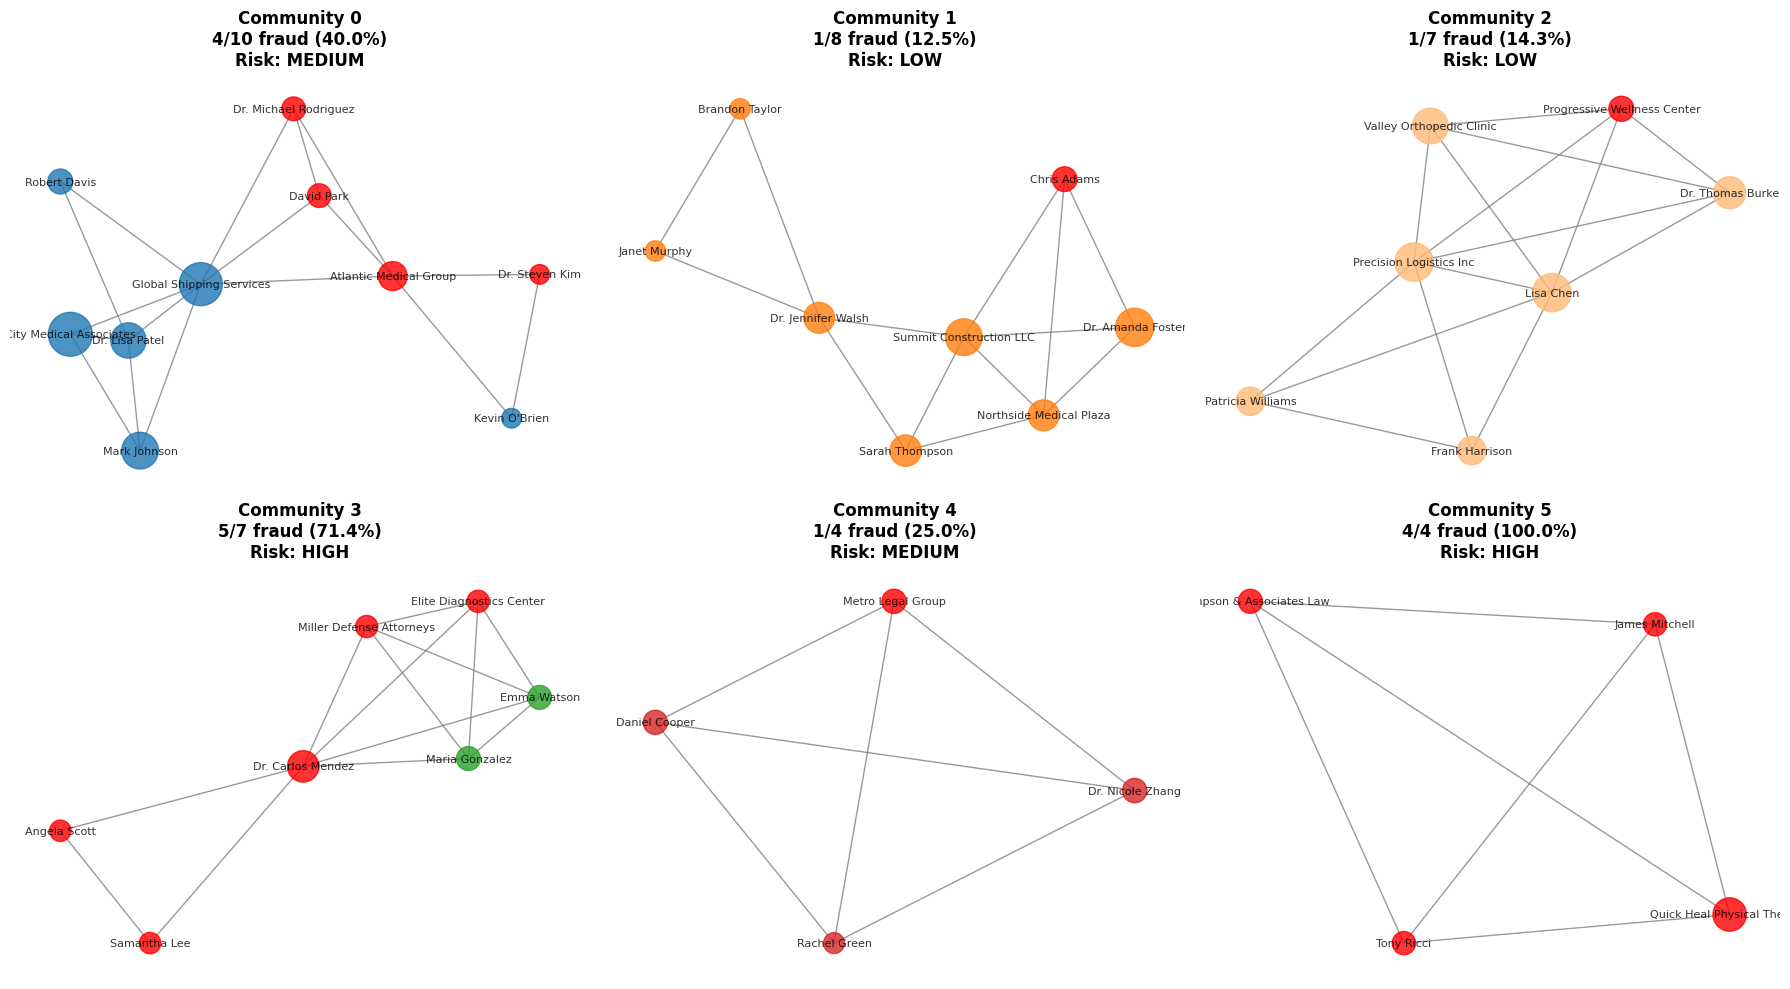

Creating interactive visualization...



WORKERS COMPENSATION FRAUD DETECTION REPORT

📊 OVERALL STATISTICS:
Total Entities: 40
Fraud Entities: 16
Overall Fraud Rate: 40.00%

🕸️ NETWORK STATISTICS:
Nodes: 40
Edges: 92
Density: 0.118
Communities Detected: 6

⚠️ HIGH-RISK COMMUNITIES (>30% fraud rate):
Community 5: 100.0% fraud rate
  Members: Quick Heal Physical Therapy, James Mitchell, Thompson & Associates Law, Tony Ricci

Community 3: 71.4% fraud rate
  Members: Miller Defense Attorneys, Maria Gonzalez, Samantha Lee, Emma Watson, Angela Scott, Elite Diagnostics Center, Dr. Carlos Mendez

Community 0: 40.0% fraud rate
  Members: Dr. Lisa Patel, Kevin O'Brien, Robert Davis, Atlantic Medical Group, Dr. Steven Kim, David Park, City Medical Associates, Mark Johnson, Global Shipping Services, Dr. Michael Rodriguez


🎯 MOST CONNECTED FRAUD ENTITIES:
Dr. Carlos Mendez (Doctor): 7 connections
Quick Heal Physical Therapy (Business): 6 connections
Atlantic Medical Group (Business): 5 connections
Elite Diagnostics Center (Business): 4 

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Dataset created: 40 entities, 20 notes
Fraud entities identified: 16
Training datasets ready for production use

🔍 Testing HUGGINGFACE NER method...
Performing Named Entity Recognition using HUGGINGFACE...
Extracted 74 entity mentions from notes
ℹ️  HuggingFace NER found 40 unique entities with confidence > 0.9
✅ HUGGINGFACE: 74 total extractions, 40 unique entities

NER ACCURACY TESTING REPORT

📋 GROUND TRUTH:
Total known entities: 40
Total notes analyzed: 20

📊 CALCULATING ACCURACY METRICS...

SPACY Metrics:
  Precision: 1.000
  Recall: 1.000
  F1 Score: 1.000
  True Positives: 40
  False Positives: 0
  False Negatives: 0

HUGGINGFACE Metrics:
  Precision: 1.000
  Recall: 1.000
  F1 Score: 1.000
  True Positives: 40
  False Positives: 0
  False Negatives: 0

🏆 BEST PERFORMING METHOD: SPACY
F1 Score: 1.000
Precision: 1.000
Recall: 1.000

🔍 ENTITY EXTRACTION ANALYSIS...

📈 EXTRACTION COMPARISON (SPACY vs HUGGINGFACE):
Both methods found: 40 entities
Only spacy: 0 entities
Only huggingf

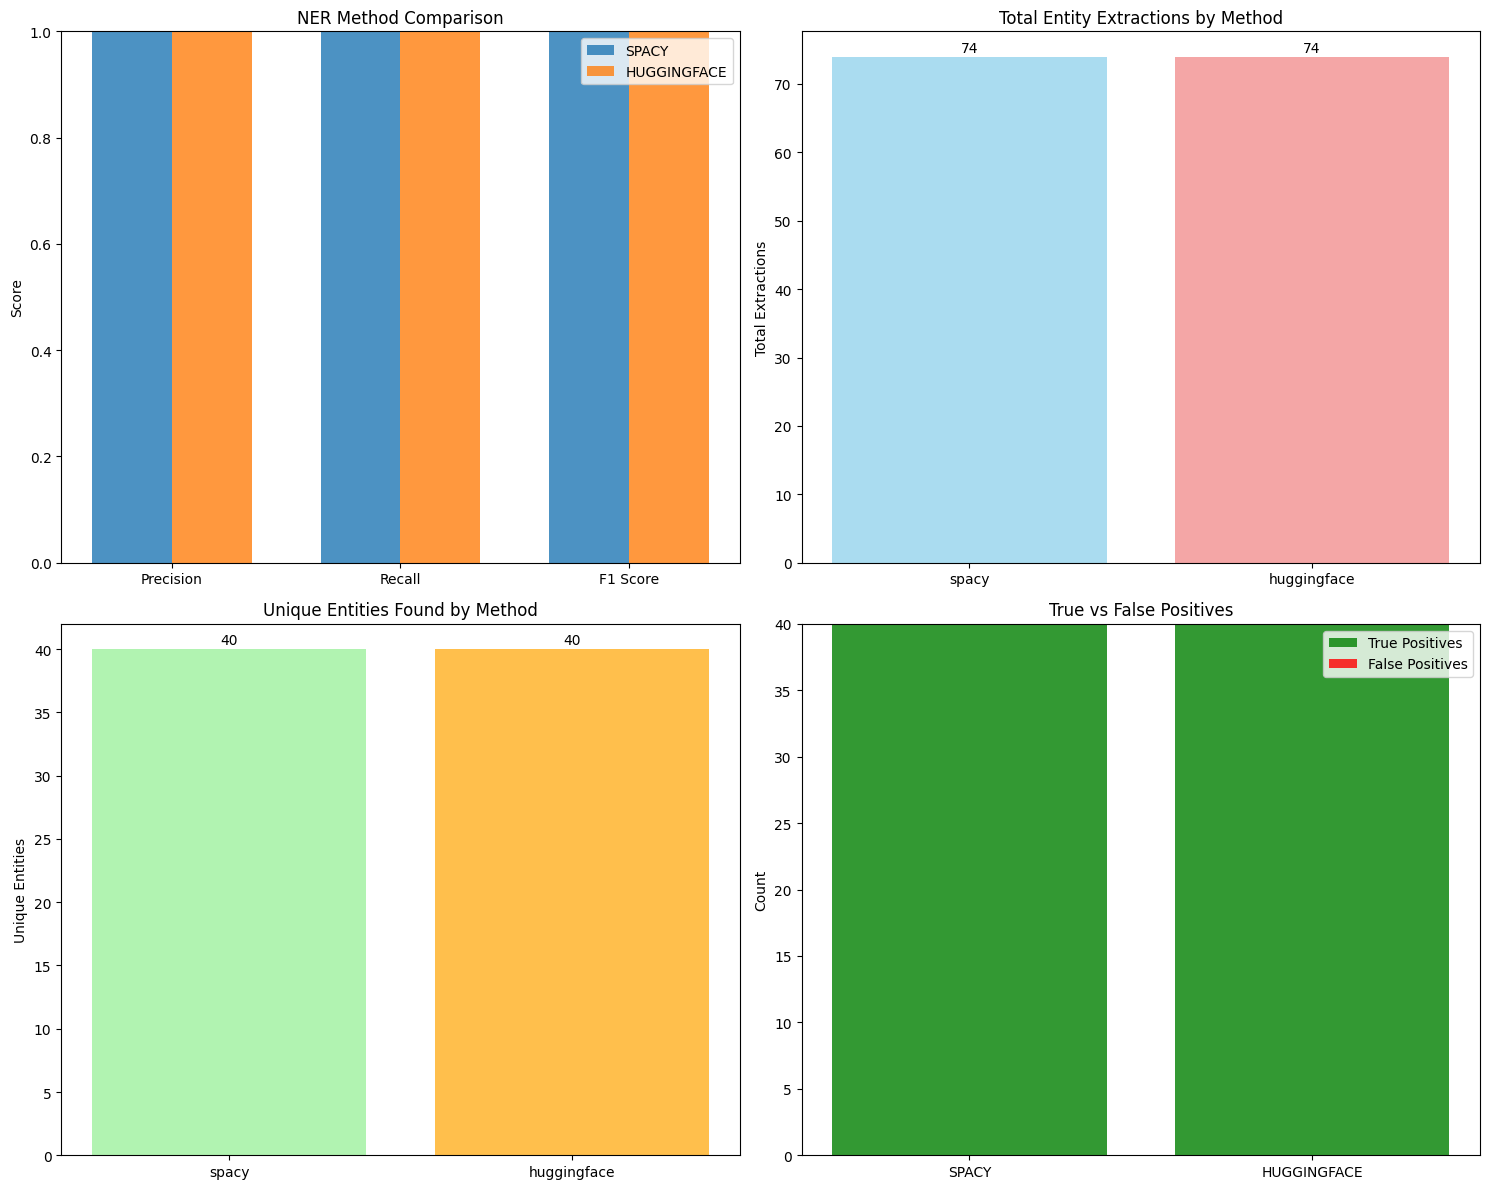



🏆 PART 3: FINAL RECOMMENDATIONS
--------------------------------------------------
🥇 Recommended NER Method: SPACY


📦 PART 4: PRODUCTION-READY OUTPUTS
--------------------------------------------------
🚀 PRODUCTION DATASETS READY:
- Entities dataset: 40 records
- Notes dataset: 20 records
- Relationships dataset: 74 records
Access via: detector.get_training_datasets()

📋 SAMPLE ENTITY RELATIONSHIPS:
   ClaimNumber NoteID                   Entity  IsFraud
0  WC-2024-001   N001           Sarah Thompson        0
1  WC-2024-001   N001  Summit Construction LLC        0
2  WC-2024-001   N001             Mark Johnson        0
3  WC-2024-001   N001  Northside Medical Plaza        0
4  WC-2024-001   N002           Sarah Thompson        0
5  WC-2024-001   N002       Dr. Jennifer Walsh        0
6  WC-2024-001   N002  Summit Construction LLC        0
7  WC-2024-001   N003           Sarah Thompson        0
8  WC-2024-001   N003       Dr. Jennifer Walsh        0
9  WC-2024-001   N003  Summit Cons

In [ ]:
if __name__ == "__main__":

    print("🎯 WORKERS COMPENSATION FRAUD DETECTION WITH NER ACCURACY TESTING")
    print("="*80)

    # ========================
    # 1. STANDARD ANALYSIS
    # ========================
    print("\n📊 PART 1: STANDARD FRAUD DETECTION ANALYSIS")
    print("-" * 50)

    # Run standard analysis with spaCy (default)
    detector = WorkersCompFraudDetector(ner_method='spacy')
    results = detector.run_complete_analysis()

    # Display standard results
    print("\n📊 CENTRALITY RANKINGS:")
    rankings = detector.get_centrality_rankings()

    print("\n🎯 TOP 5 by Combined Importance:")
    print(rankings['by_combined'][['Entity', 'Combined_Importance', 'Is_Fraud']].head())

    print("\n🔗 TOP 5 by Degree Centrality:")
    print(rankings['by_degree'][['Entity', 'Degree_Centrality', 'Is_Fraud']].head())

    print("\n🌉 TOP 5 by Betweenness Centrality:")
    print(rankings['by_betweenness'][['Entity', 'Betweenness_Centrality', 'Is_Fraud']].head())

    # ========================
    # 2. NER ACCURACY TESTING
    # ========================
    print("\n\n🔬 PART 2: NER ACCURACY TESTING")
    print("-" * 50)

    # Get ground truth data for testing
    entities_df = detector.get_training_datasets()['entities']
    notes_df = detector.get_training_datasets()['notes']

    # Run comprehensive NER accuracy testing
    tester, test_report = run_ner_accuracy_test(
        WorkersCompFraudDetector,
        entities_df,
        notes_df
    )

    # ========================
    # 3. METHOD COMPARISON & RECOMMENDATION
    # ========================
    if test_report:
        print("\n\n🏆 PART 3: FINAL RECOMMENDATIONS")
        print("-" * 50)

        best_method = test_report['best_method']
        print(f"🥇 Recommended NER Method: {best_method.upper()}")

        # Re-run analysis with best method if it's different from what we used
        if best_method != 'spacy':
            print(f"\n🔄 Re-running analysis with optimal method ({best_method.upper()})...")

            optimal_detector = WorkersCompFraudDetector(ner_method=best_method)
            optimal_results = optimal_detector.run_complete_analysis()

            print(f"\n📈 OPTIMAL METHOD RESULTS:")
            optimal_rankings = optimal_detector.get_centrality_rankings()
            print("\n🎯 TOP 5 by Combined Importance (Optimal Method):")
            print(optimal_rankings['by_combined'][['Entity', 'Combined_Importance', 'Is_Fraud']].head())

    # ========================
    # 4. PRODUCTION DATASETS
    # ========================
    print("\n\n📦 PART 4: PRODUCTION-READY OUTPUTS")
    print("-" * 50)

    # Get production datasets
    training_data = detector.get_training_datasets()
    print(f"🚀 PRODUCTION DATASETS READY:")
    print(f"- Entities dataset: {len(training_data['entities'])} records")
    print(f"- Notes dataset: {len(training_data['notes'])} records")
    print(f"- Relationships dataset: {len(training_data['relationships'])} records")
    print("Access via: detector.get_training_datasets()")

    # Entity relationship sample
    print("\n📋 SAMPLE ENTITY RELATIONSHIPS:")
    print(detector.extracted_entities.head(10))

    # Community analysis summary
    print("\n🏘️ COMMUNITY RISK SUMMARY:")
    community_summary = detector.community_table.sort_values('Fraud_Ratio', ascending=False)
    print(community_summary[['Community_ID', 'Total_Members', 'Fraud_Ratio', 'Risk_Level']].head())

    # ========================
    # 5. ACCURACY METRICS SUMMARY
    # ========================
    if tester and test_report:
        print("\n\n📊 PART 5: NER ACCURACY SUMMARY")
        print("-" * 50)

        print("🎯 METHOD PERFORMANCE SUMMARY:")
        for method, metrics in test_report['metrics_summary'].items():
            print(f"\n{method.upper()}:")
            print(f"  • Precision: {metrics['precision']:.3f} (how many found entities were correct)")
            print(f"  • Recall: {metrics['recall']:.3f} (how many total entities were found)")
            print(f"  • F1 Score: {metrics['f1_score']:.3f} (balanced accuracy measure)")
            print(f"  • False Positives: {metrics['false_positives']} (incorrect entities found)")
            print(f"  • Missed Entities: {metrics['false_negatives']} (correct entities missed)")

    print("\n" + "="*80)
    print("✅ COMPLETE ANALYSIS FINISHED!")
    print("Ready for production fraud detection implementation.")
    print("="*80)